In [1]:
import pandas as pd
from time import perf_counter

import spacy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


In [2]:
n_features = 1000
n_components = 4
n_top_words = 15
batch_size = 128


In [3]:
print("Loading dataset...")
t0 = perf_counter()
# Load the csv file
data_samples = (
    pd.read_csv("Medium_articles_3.csv", usecols=["text"]).squeeze(axis=1).dropna()
)
print(f"done in {perf_counter() - t0:.2f}s")


Loading dataset...
done in 0.05s


In [4]:
# download spacy sm model
# !python -m spacy download en_core_web_sm
# prefer gpu
spacy.prefer_gpu()
# load spacy
nlp = spacy.load("en_core_web_sm")

In [5]:
# using spacy for generating tokens (words).
def tokenizer(doc):
    with nlp.select_pipes(disable=["tok2vec", "parser", "ner"]):
        return [
            word
            for token in nlp(doc)
            if (word := token.lemma_.lower().strip())
            and not token.is_stop
            and token.is_alpha
        ]


In [6]:
# ploting graph based on model
def plot_top_words(model, feature_names, n_top_words, title):
    """
    PlotiSTOP_WORDSraph for model with it's features
    """
    fig, axes = plt.subplots(1, n_components, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


In [7]:
# Use tf (raw term count) features for LDA.
tf_vectorizer = CountVectorizer(
    max_df=0.9,
    min_df=2,
    tokenizer=tokenizer,
    max_features=n_features,
    ngram_range=(1, 2),
)
t0 = perf_counter()
tf = tf_vectorizer.fit_transform(data_samples)
print(f"done in {perf_counter() - t0:.2f}s")


done in 19.28s


done in 2.48s


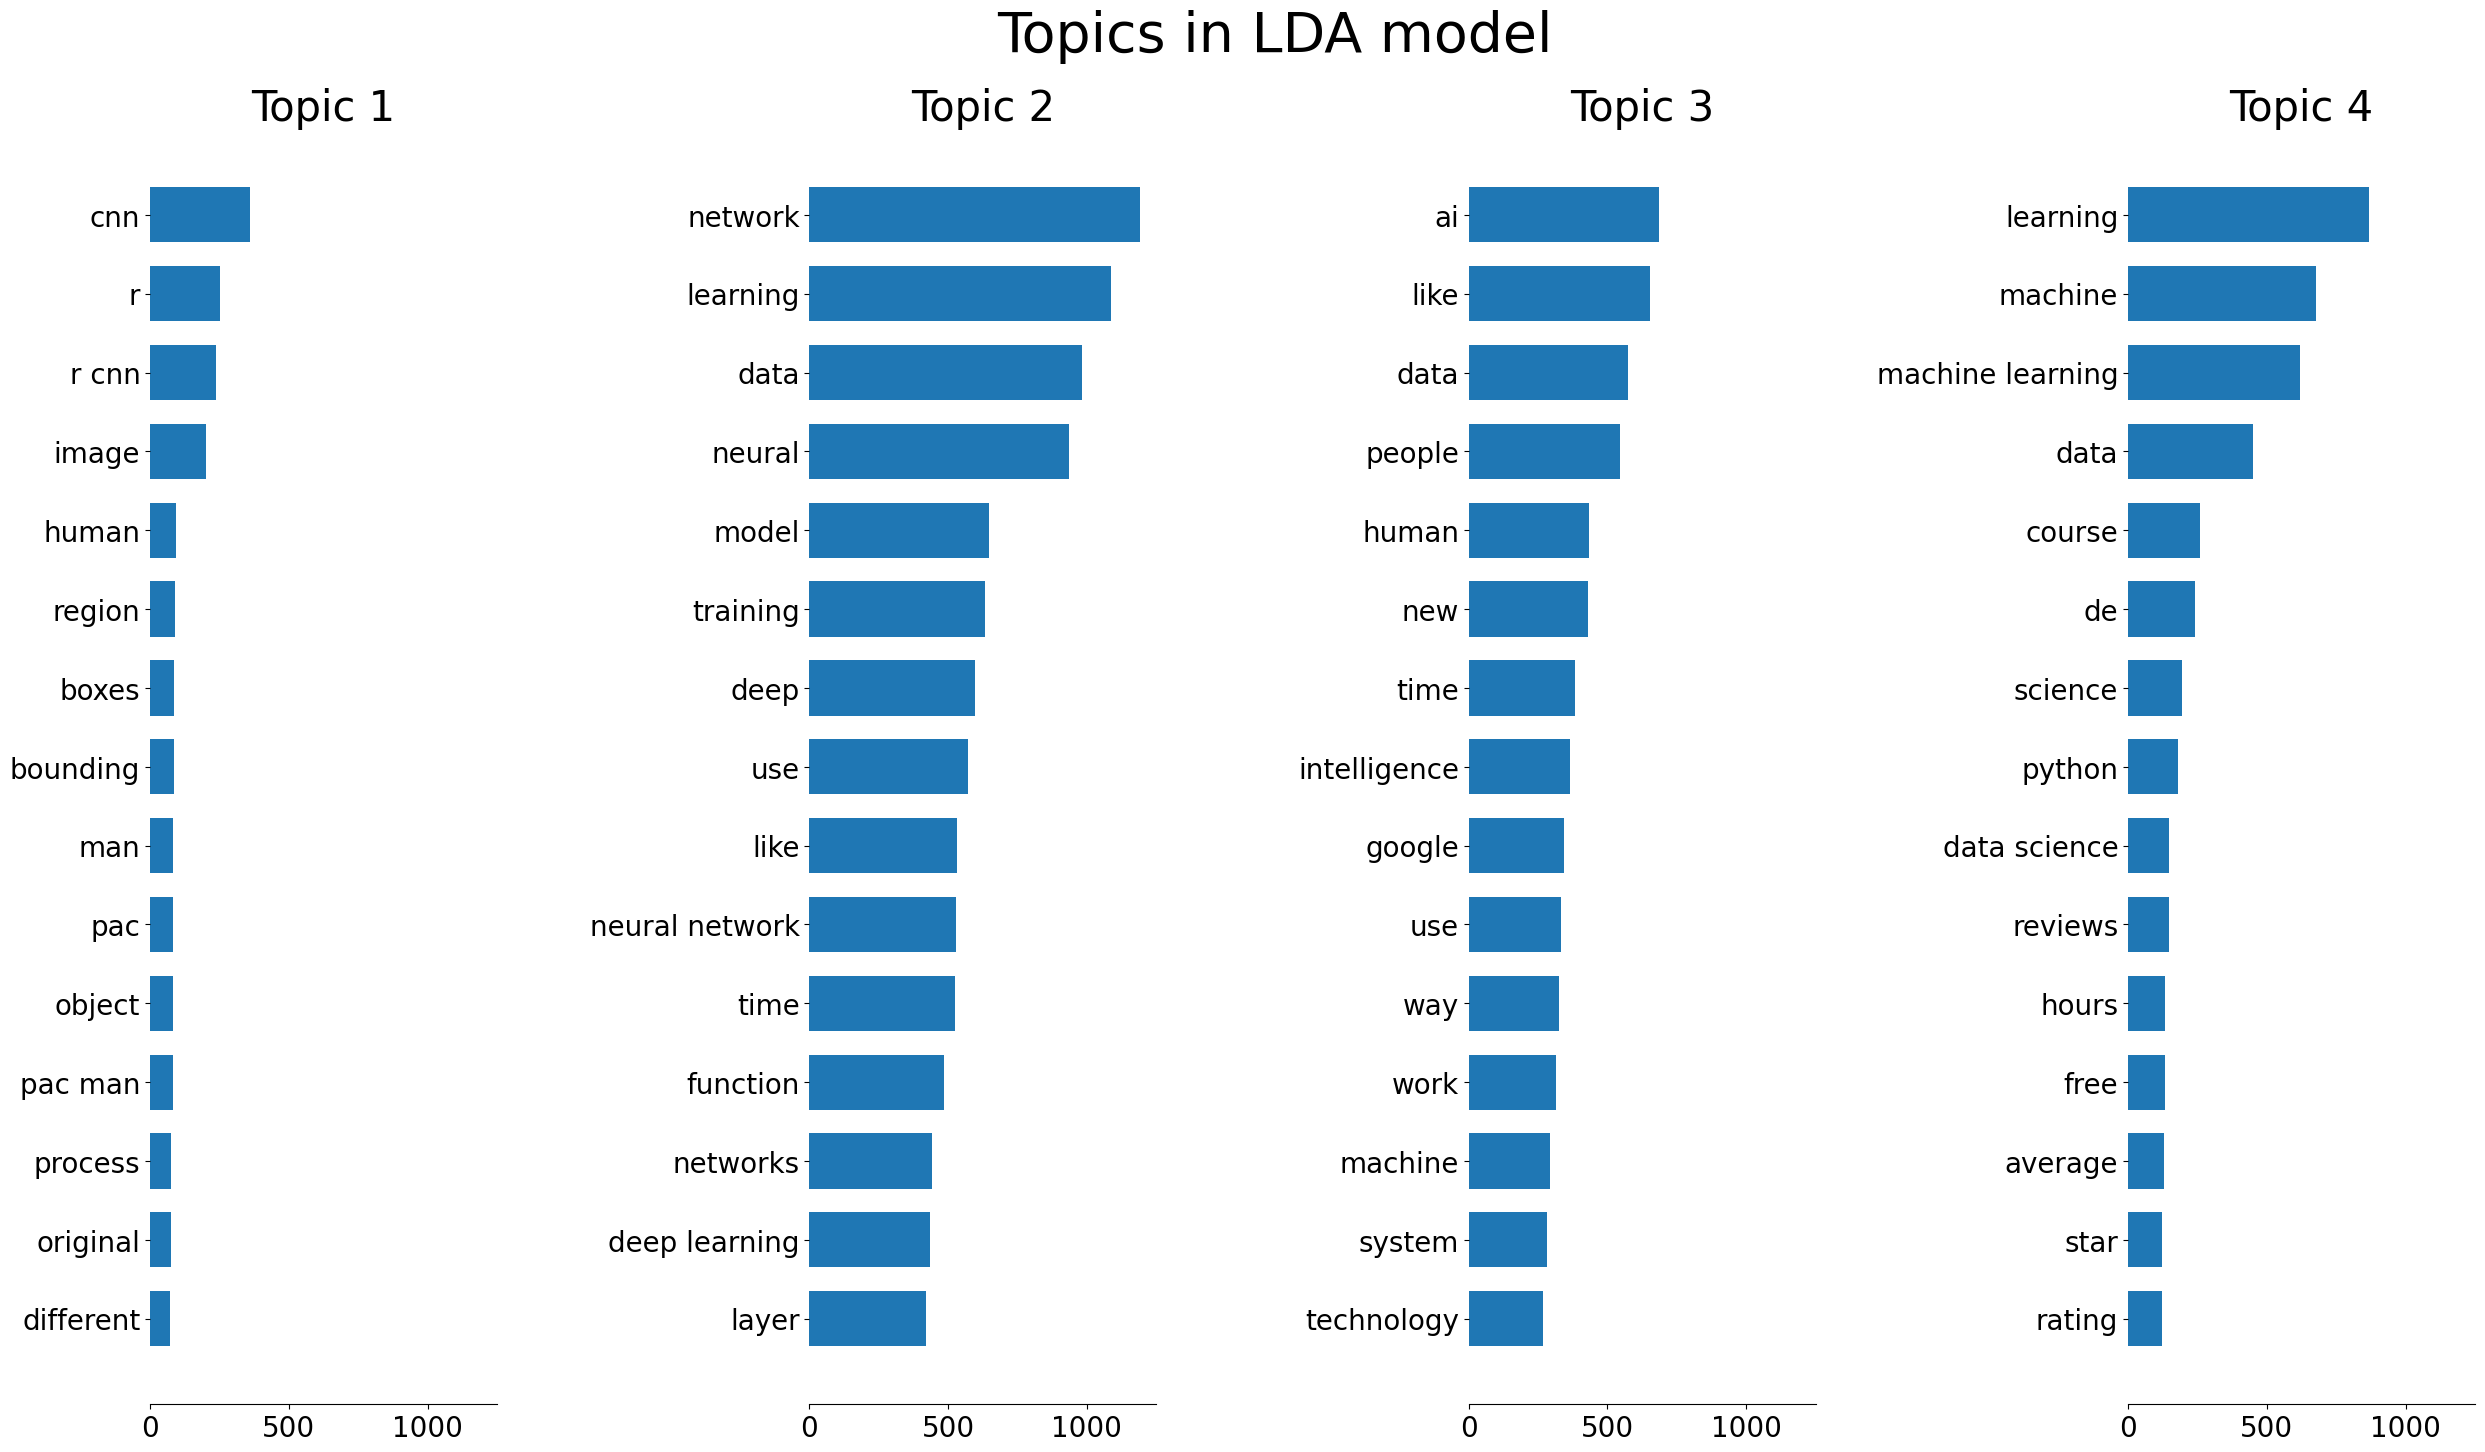

In [8]:
# Fitting LDA models with tf features
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=10,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = perf_counter()
lda.fit(tf)
print(f"done in {perf_counter() - t0:.2f}s")

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")
